In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import keras.utils.to_categorical
#import keras_utils
from keras.datasets import cifar10
from megaman.geometry import Geometry

Using TensorFlow backend.


In [2]:
# Load dataset
(X_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# Shuffle dataset
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [4]:
# 10 Classes in CIFAR-10
label_dict = {
 0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck',
}

Text(0.5,1,'Label: cat')
Text(0.5,1,'Label: ship')
Text(0.5,1,'Label: bird')
Text(0.5,1,'Label: truck')
Text(0.5,1,'Label: deer')
Text(0.5,1,'Label: automobile')


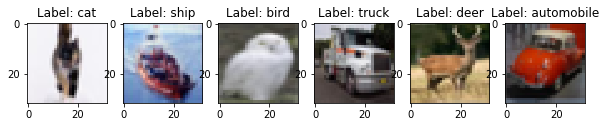

In [16]:
#Test plot of images
plt.figure(figsize=[10,5])
for i in range(6):
    plt.subplot(1,6,i+1)
    curr_img = np.reshape(X_train[i], (32,32,3))
    plt.imshow(curr_img)
    print(plt.title("Label: " + str(label_dict[y_train[i][0]])))

In [5]:
def plot_embedding(X, y, title=None):
    """
    In: Data batch X, labels y, title of plot
    Plots the first 2 dimensions of embedding using the number of the 10 classes
    to show clustering
    """
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(18, 12))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 22})

    plt.xticks([]), plt.yticks([])
    plt.figtext(.5,.9, str(title), fontsize=30, ha='center')
    #if title is not None:
     #   plt.title(title)
        
    plt.savefig(str(title) + '.png' , format = 'png') 

In [6]:
# Reshape training data to 2d
X_train = X_train.reshape((50000,-1))

In [7]:
#Setup batchsize
batchsize = 8092
X_train_batch = X_train[:batchsize, :]
y_train_batch = y_train[:batchsize]

In [30]:
X_train_batch.shape

(8092, 3072)

In [8]:
# Normalize data, StandardScaler does not bring good results
from sklearn import preprocessing
X_train_batch = preprocessing.normalize(X_train_batch)

In [9]:
# Resize labels to 1D
y_train_batch = y_train_batch.reshape((batchsize,))

/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning:

Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.



(8092, 2)


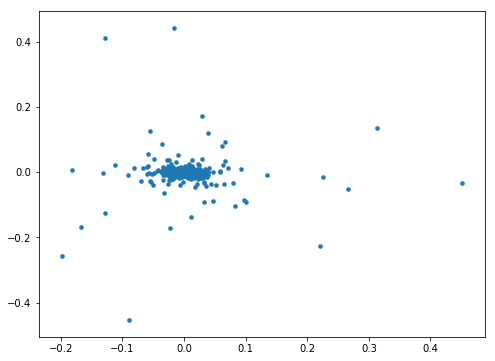

In [33]:
# Simple example from manifold_intro tutorial
from megaman.embedding import LTSA
from megaman.geometry import Geometry

geom = Geometry(adjacency_kwds=dict(n_neighbors=64))
model = LTSA(geom=geom, eigen_solver='dense', random_state=64)

X_ltsa = model.fit_transform(X_train_batch)
print(X_ltsa.shape)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_ltsa[:, 1], X_ltsa[:, 0], s=20, lw=0.1)

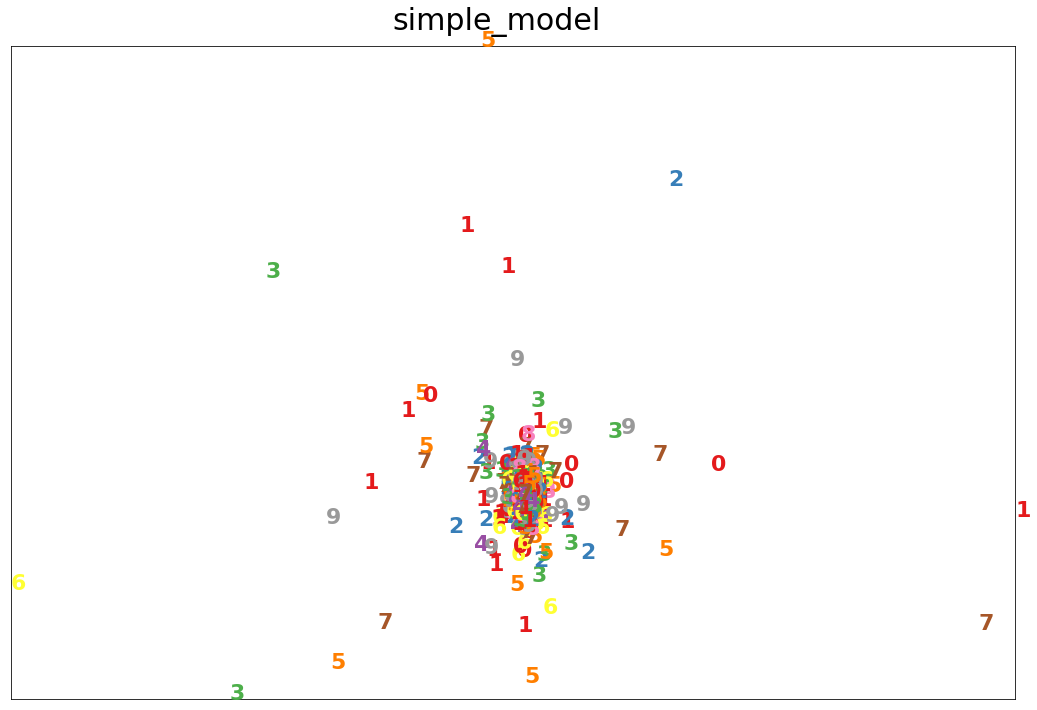

In [34]:
plot_embedding(X_ltsa, y_train_batch, 'simple_model')

# # Radius Estimation

In [25]:
#Set rmin and rmax as the intervall to search the optimal radius

rmax=2
rmin=0.1
# Calculate Adjacency matrix of Data batch
geom = Geometry(adjacency_method='brute',adjacency_kwds=dict(radius=rmax))
geom.set_data_matrix(X_train_batch)
dist = geom.compute_adjacency_matrix()

In [26]:
from megaman.utils.estimate_radius import run_estimate_radius

# subsample by 10.
sample = np.arange(0,X_train_batch.shape[0],10)

# Run 1D embedding radius search
distorion_vs_rad_dim1 = run_estimate_radius(
    X_train_batch, dist, sample=sample, d=1, rmin=rmin, rmax=rmax,
    ntry=10, run_parallel=True, search_space='logspace')

# Run 2D embedding radius search
distorion_vs_rad_dim2 = run_estimate_radius(
    X_train_batch, dist, sample=sample, d=2, rmin=rmin, rmax=rmax,
    ntry=10, run_parallel=True, search_space='logspace')

# Get radius with smallest distortion (optimal)and compare 1D against 2D
distorsion_dim1 = distorion_vs_rad_dim1[:,1].astype('float64')
distorsion_dim2 = distorion_vs_rad_dim2[:,1].astype('float64')
rad_search_space = distorion_vs_rad_dim1[:,0].astype('float64')

argmin_d1 = np.argmin(distorsion_dim1)
argmin_d2 = np.argmin(distorsion_dim2)
est_rad_dim1 = rad_search_space[argmin_d1]
est_rad_dim2 = rad_search_space[argmin_d2]

print ('Estimated radius with d=2 is: {:.4f}'.format(est_rad_dim1))
print ('Estimated radius with d=1 is: {:.4f}'.format(est_rad_dim2))

using 4 processes to perform asynchronous parallel radius search
performing parallel radius search...

for radius: 0.194588771758 distortion is: inf
for radius: 0.194588771758 analysis took: 0.022394180297851562 seconds

for radius: 0.1 distortion is: inf
for radius: 0.1 analysis took: 0.03618597984313965 seconds

for radius: 0.271441761659 distortion is: inf
for radius: 0.271441761659 analysis took: 0.040140628814697266 seconds

for radius: 0.139495079396 distortion is: inf
for radius: 0.139495079396 analysis took: 0.048003196716308594 seconds



/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


for radius: 0.378647900941 distortion is: 0.992232160245
for radius: 0.378647900941 analysis took: 80.14442300796509 seconds

for radius: 0.528195190051 distortion is: 0.842253169234
for radius: 0.528195190051 analysis took: 353.13550996780396 seconds

for radius: 0.736806299728 distortion is: 0.455771730112
for radius: 0.736806299728 analysis took: 390.59131479263306 seconds

for radius: 1.0278085328 distortion is: 1.01225831432
for radius: 1.0278085328 analysis took: 392.1431791782379 seconds

for radius: 1.43374232887 distortion is: 0.683824153803
for radius: 1.43374232887 analysis took: 342.83454847335815 seconds

for radius: 2.0 distortion is: 0.634846940373
for radius: 2.0 analysis took: 121.3065538406372 seconds

analysis took: 474.6882576942444 seconds to complete.
using 4 processes to perform asynchronous parallel radius search
performing parallel radius search...

for radius: 0.194588771758 distortion is: inf
for radius: 0.194588771758 analysis took: 0.031629085540771484 seco

In [27]:
# Plot results
import plotly
plotly.offline.init_notebook_mode(connected=True)

from IPython.core.display import display, HTML
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

In [28]:
from megaman.plotter.scatter_3d import scatter_plot3d_plotly
import plotly.graph_objs as go
from plotly.offline import iplot


t_distorsion = [go.Scatter(x=rad_search_space, y=distorsion_dim1, name='Dimension = 1'), 
                go.Scatter(x=rad_search_space, y=distorsion_dim2, name='Dimension = 2')]

l_distorsion = go.Layout(
    title='Distorsions versus radii',
    xaxis=dict(
        title='$\\text{Radius } r$',
        type='log',
        autorange=True
    ),
    yaxis=dict(
        title='Distorsion',
        type='log',
        autorange=True
    ),
    annotations=[
        dict(
            x=np.log10(est_rad_dim1),
            y=np.log10(distorsion_dim1[argmin_d1]),
            xref='x',
            yref='y',
            text='$\\hat{r}_{d=1}$',
            font = dict(size = 30),
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-30
        ),
        dict(
            x=np.log10(est_rad_dim2),
            y=np.log10(distorsion_dim2[argmin_d2]),
            xref='x',
            yref='y',
            text='$\\hat{r}_{d=2}$',
            font = dict(size = 30),
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-30
        )
    ]
)
f_distorsion = go.Figure(data=t_distorsion,layout=l_distorsion)
iplot(f_distorsion)

## Run Embedding

In [35]:
# Initialize Geometry object for embedding
geom = Geometry()
geom.set_data_matrix(X_train_batch)

In [36]:
# Radius Backtesting. In general, small radius but large enough to result in a fully connected graph
# (or at least a single large enough connected component) [taken from the megaman tutorial]
from scipy.sparse.csgraph import connected_components
rad1 = 1.2
# compute an adjacency matrix with a radius
geom.adjacency_kwds = {'radius':rad1}
adjacency_matrix = geom.compute_adjacency_matrix()
# compute the corresponding affinity matrix
geom.affinity_kwds = {'radius':rad1}
affinity_matrix = geom.compute_affinity_matrix({'radius':rad1})
(number_connected_components, labels) = connected_components(affinity_matrix)
print(number_connected_components)

1


In [10]:
# Define parameters for geometry object
radius = 1.15
adjacency_method = 'cyflann'
adjacency_kwds = {'radius':radius}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}
laplacian_method = 'symmetricnormalized'
laplacian_kwds = {'scaling_epps':radius}

geom  = {'adjacency_method':adjacency_method, 'adjacency_kwds':adjacency_kwds,
         'affinity_method':affinity_method, 'affinity_kwds':affinity_kwds,
         'laplacian_method':laplacian_method, 'laplacian_kwds':laplacian_kwds}

# Setup geometry object
geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)
geom.set_data_matrix(X_train_batch)

In [11]:
# Finally run embeddings
from megaman.embedding import (Isomap, LocallyLinearEmbedding, LTSA, SpectralEmbedding)
# 2D embeddings
n_components = 2

In [ ]:
spectral = SpectralEmbedding(n_components=3, eigen_solver='amg',geom=geom, drop_first=False) # use 3 for spectral
embed_spectral = spectral.fit_transform(X_train_batch)

ltsa = LTSA(n_components=n_components,eigen_solver='dense',geom=geom)
embed_ltsa = ltsa.fit_transform(X_train_batch)

lle = LocallyLinearEmbedding(n_components=n_components, eigen_solver='dense',geom=geom)
embed_lle = lle.fit_transform(X_train_batch)

isomap = Isomap(n_components=n_components, eigen_solver='dense',geom=geom)
embed_isomap = isomap.fit_transform(X_train_batch)

/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", Deprecati

In [ ]:
# Small plot
embed_spectral = embed_spectral[:, [0, 2]] * 50.0
tmp = embed_spectral[:, 1].copy()
embed_spectral[:,1] = embed_spectral[:,0].copy()
embed_spectral[:,0] = tmp.copy()
tmp = None

fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].scatter(embed_ltsa[:, 0], embed_ltsa[:, 1], s=1, c=y_train_batch)
axes[0, 0].set_title('LTSA')
axes[0, 1].scatter(embed_lle[:, 0], embed_lle[:, 1], s=1, c=y_train_batch)
axes[0, 1].set_title('LLE')
axes[1, 0].scatter(embed_isomap[:, 0], embed_isomap[:, 1], s=1, c=y_train_batch)
axes[1, 0].set_title('Isomap')
axes[1, 1].scatter(embed_spectral[:, 0], embed_spectral[:, 1], s=1, c=y_train_batch)
axes[1, 1].set_title('Spectral Embedding')
plt.show()

## Plot final embeddings

In [ ]:
plot_embedding(embed_ltsa, y_train_batch, 'Megaman LTSA Embedding')

In [ ]:
plot_embedding(embed_lle, y_train_batch, 'Megaman LLE Embedding')

In [ ]:
plot_embedding(embed_isomap, y_train_batch, 'Megaman Isomap Embedding')

In [ ]:
plot_embedding(embed_spectral, y_train_batch, 'Megaman Spectral Embedding')

## Determine Accuracy of embedding using KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
# Spectral Embedding
knn = KNeighborsClassifier(n_neighbors=4)
# Train the model using the training sets
knn.fit(embed_spectral, y_train_batch)

#Predict Output
predicted = knn.predict(embed_spectral) 

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_train_batch, predicted))

In [ ]:
# LTSA Embedding
knn = KNeighborsClassifier(n_neighbors=4)
# Train the model using the training sets
knn.fit(embed_ltsa, y_train_batch)

#Predict Output
predicted = knn.predict(embed_ltsa) 

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_train_batch, predicted))

In [ ]:
# LLE Embedding
knn = KNeighborsClassifier(n_neighbors=4)
# Train the model using the training sets
knn.fit(embed_lle, y_train_batch)

#Predict Output
predicted = knn.predict(embed_lle) 

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_train_batch, predicted))

In [ ]:
# LLE Embedding
knn = KNeighborsClassifier(n_neighbors=4)
# Train the model using the training sets
knn.fit(embed_isomap, y_train_batch)

#Predict Output
predicted = knn.predict(embed_isomap) 

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_train_batch, predicted))